Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.


Инструкция по выполнению проекта:


Загрузите данные и выполните их ресемплирование по одному часу.
Проанализируйте данные.
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
Проверьте данные на тестовой выборке и сделайте выводы.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
!pip install catboost

In [134]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [99]:
df = pd.read_csv("C://Users/Владислав/Desktop/Новая папка/Data sceince/Временные ряды/taxi.csv")
df.tail(1000)

,datetime,num_orders
25496,2018-08-25 01:20:00,24
25497,2018-08-25 01:30:00,31
25498,2018-08-25 01:40:00,40
25499,2018-08-25 01:50:00,44
25500,2018-08-25 02:00:00,36
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Приведем столбец с данными к datetime

In [101]:
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y.%m.%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Выполним ресемплирование по 1 часу

In [102]:
df_res = df.resample('1H', on='datetime').sum()

In [8]:
print(df.index.is_monotonic)

True


#### Анализ

Построим график сезонности по ресемплированной выборке по 1 часу

Text(0.5, 1.0, 'Seasonality')

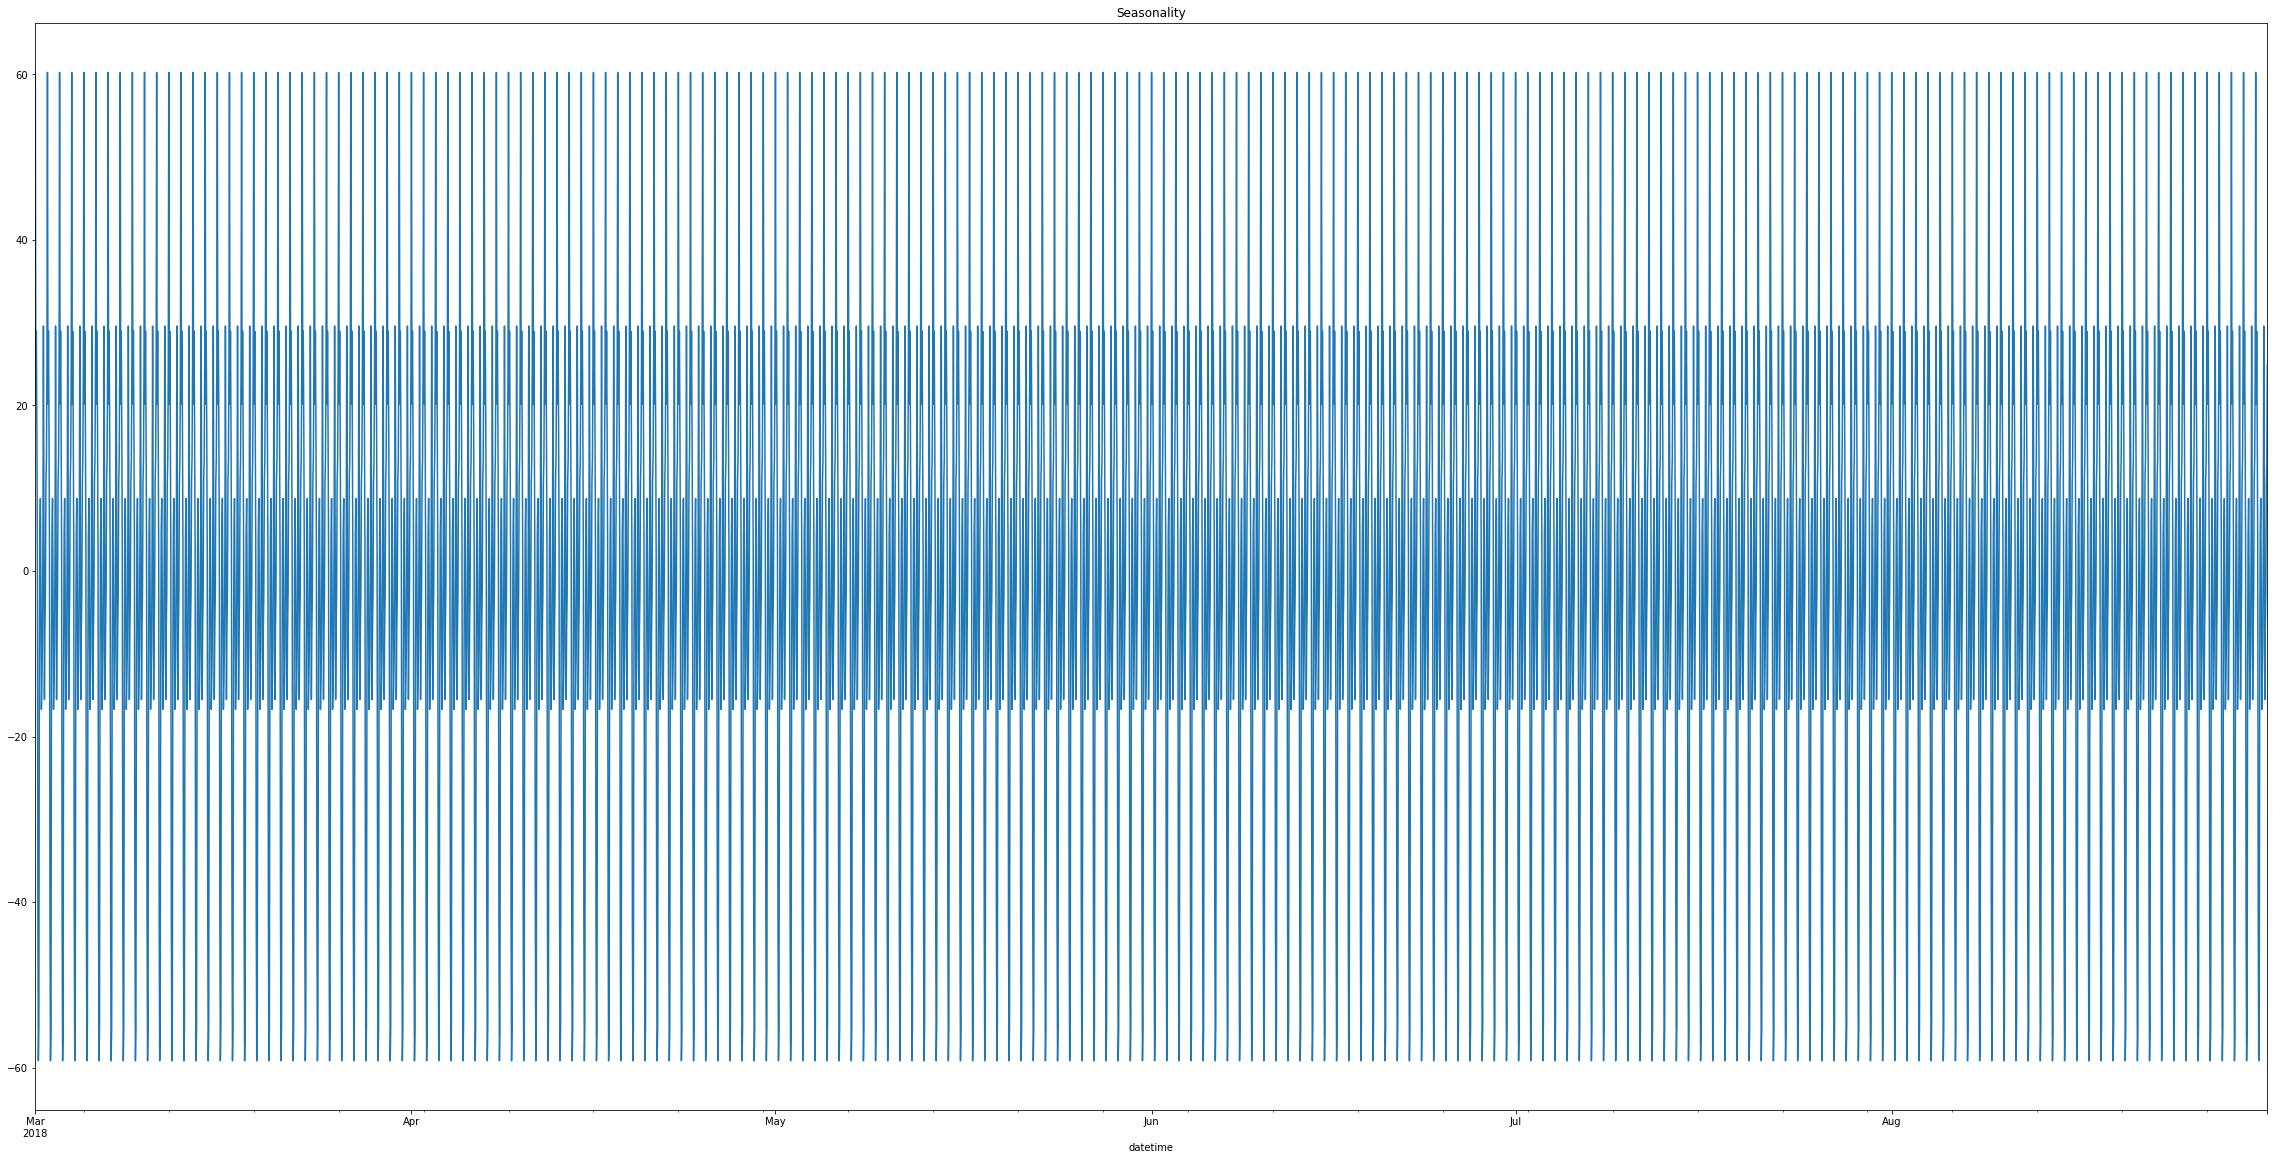

In [103]:
df_res.sort_index(inplace=True)
plt.figure(figsize=(40, 20))
decomposed = seasonal_decompose(df_res)
print(decomposed)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')


Анализировать подобный график не представляется возможным из-за обилия данных. Ресемплируем по дням

Text(0.5, 1.0, 'Seasonality')

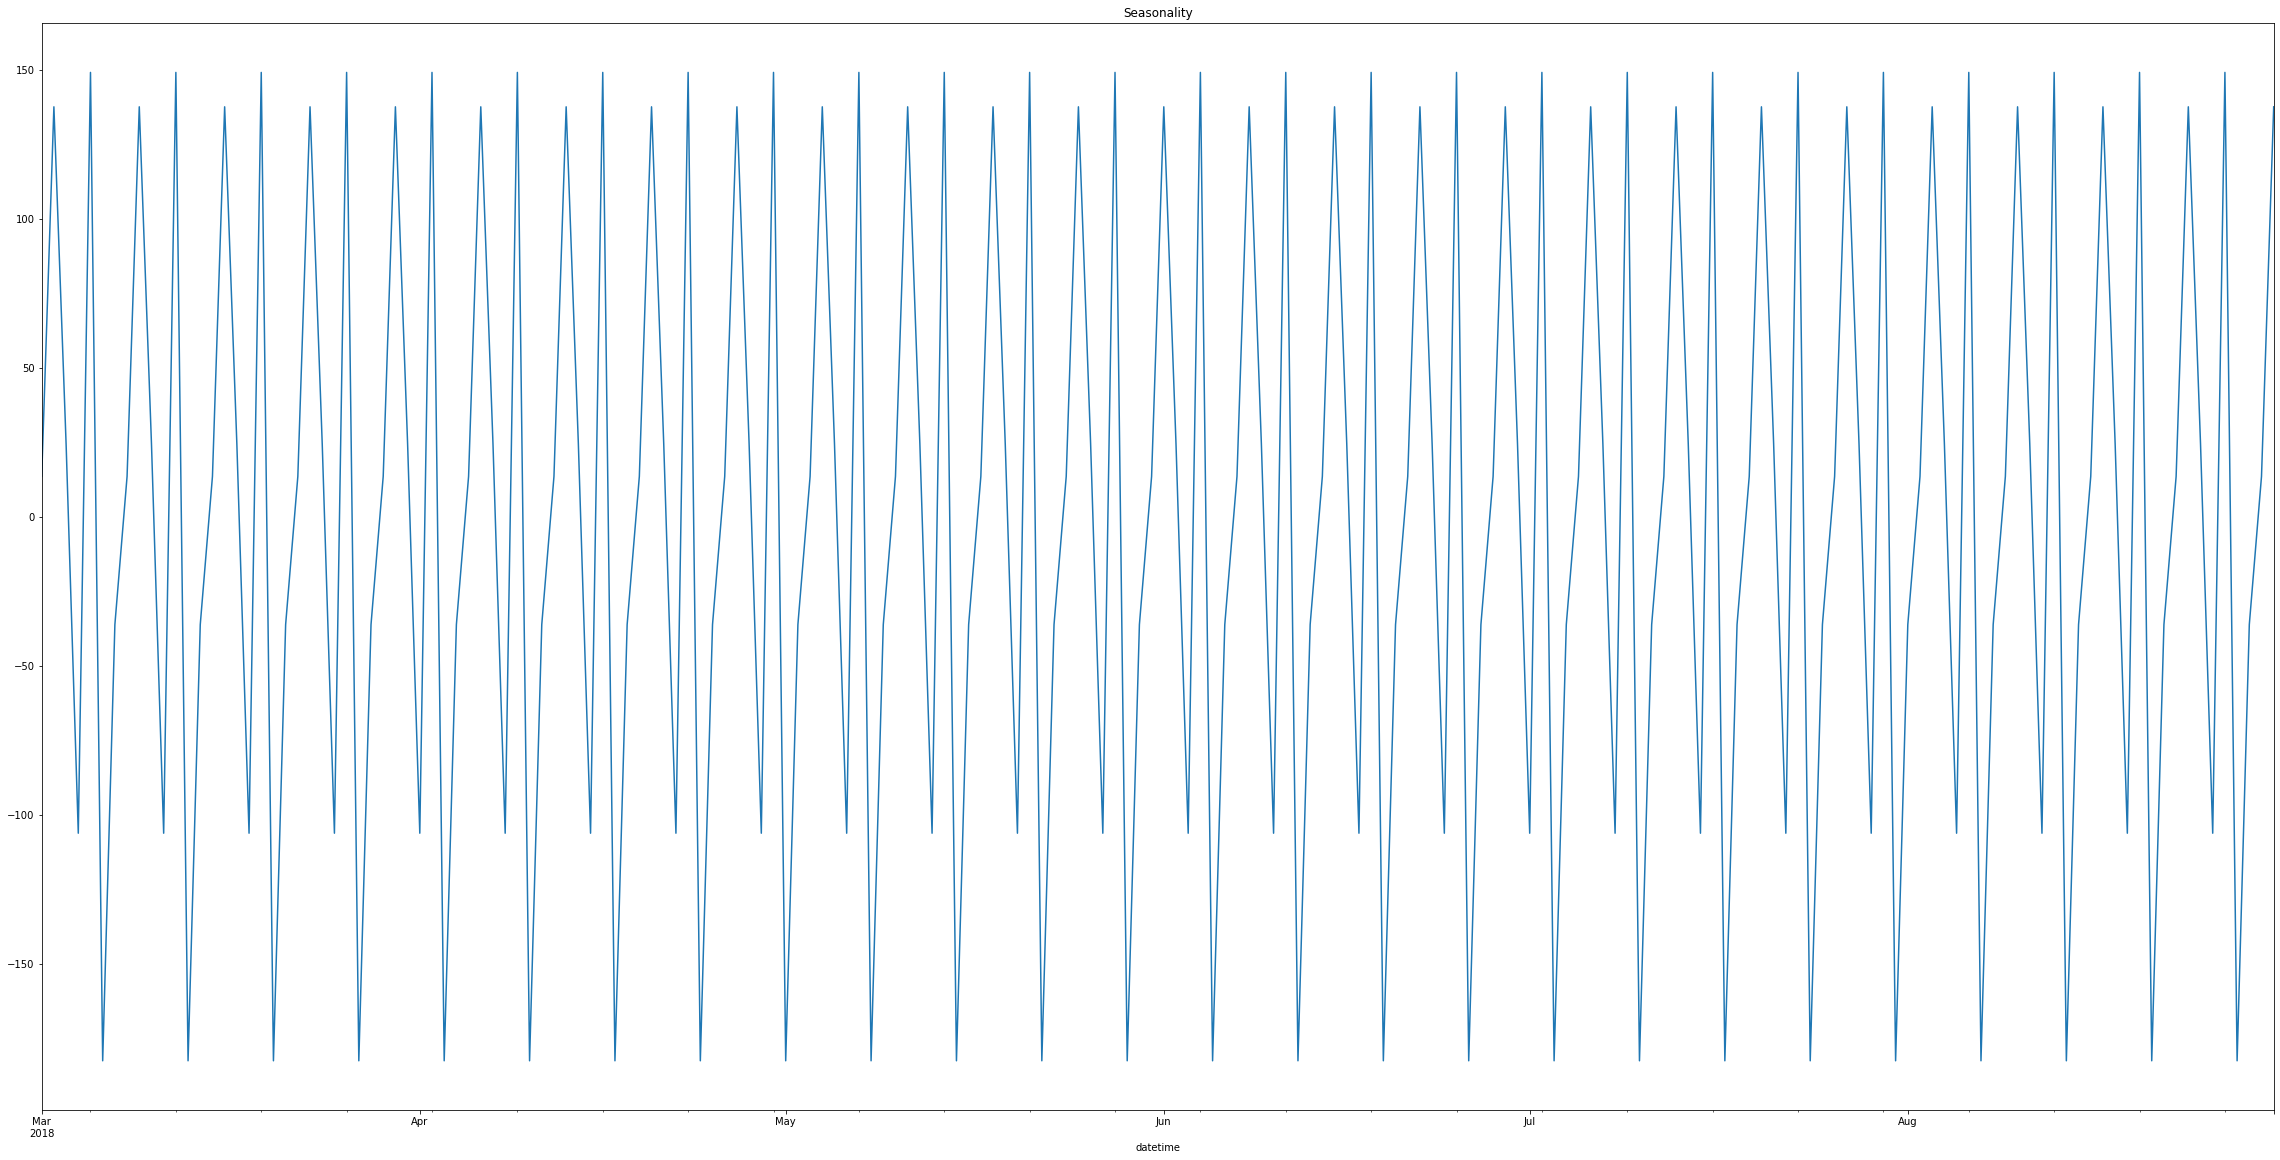

In [10]:
df_res_d = df.resample('1D', on='datetime').sum()
df_res_d.sort_index(inplace=True)
plt.figure(figsize=(40, 20))
decomposed = seasonal_decompose(df_res_d)
print(decomposed)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')


Есть выраженная циклическая закономерность в течение месяца. Точнее 4 цикла в каждом месяце. Предполагаю, что эло связано с выходными. Возьмем заддые за 2 недели по 1 часу. 

Text(0.5, 1.0, 'Seasonality')

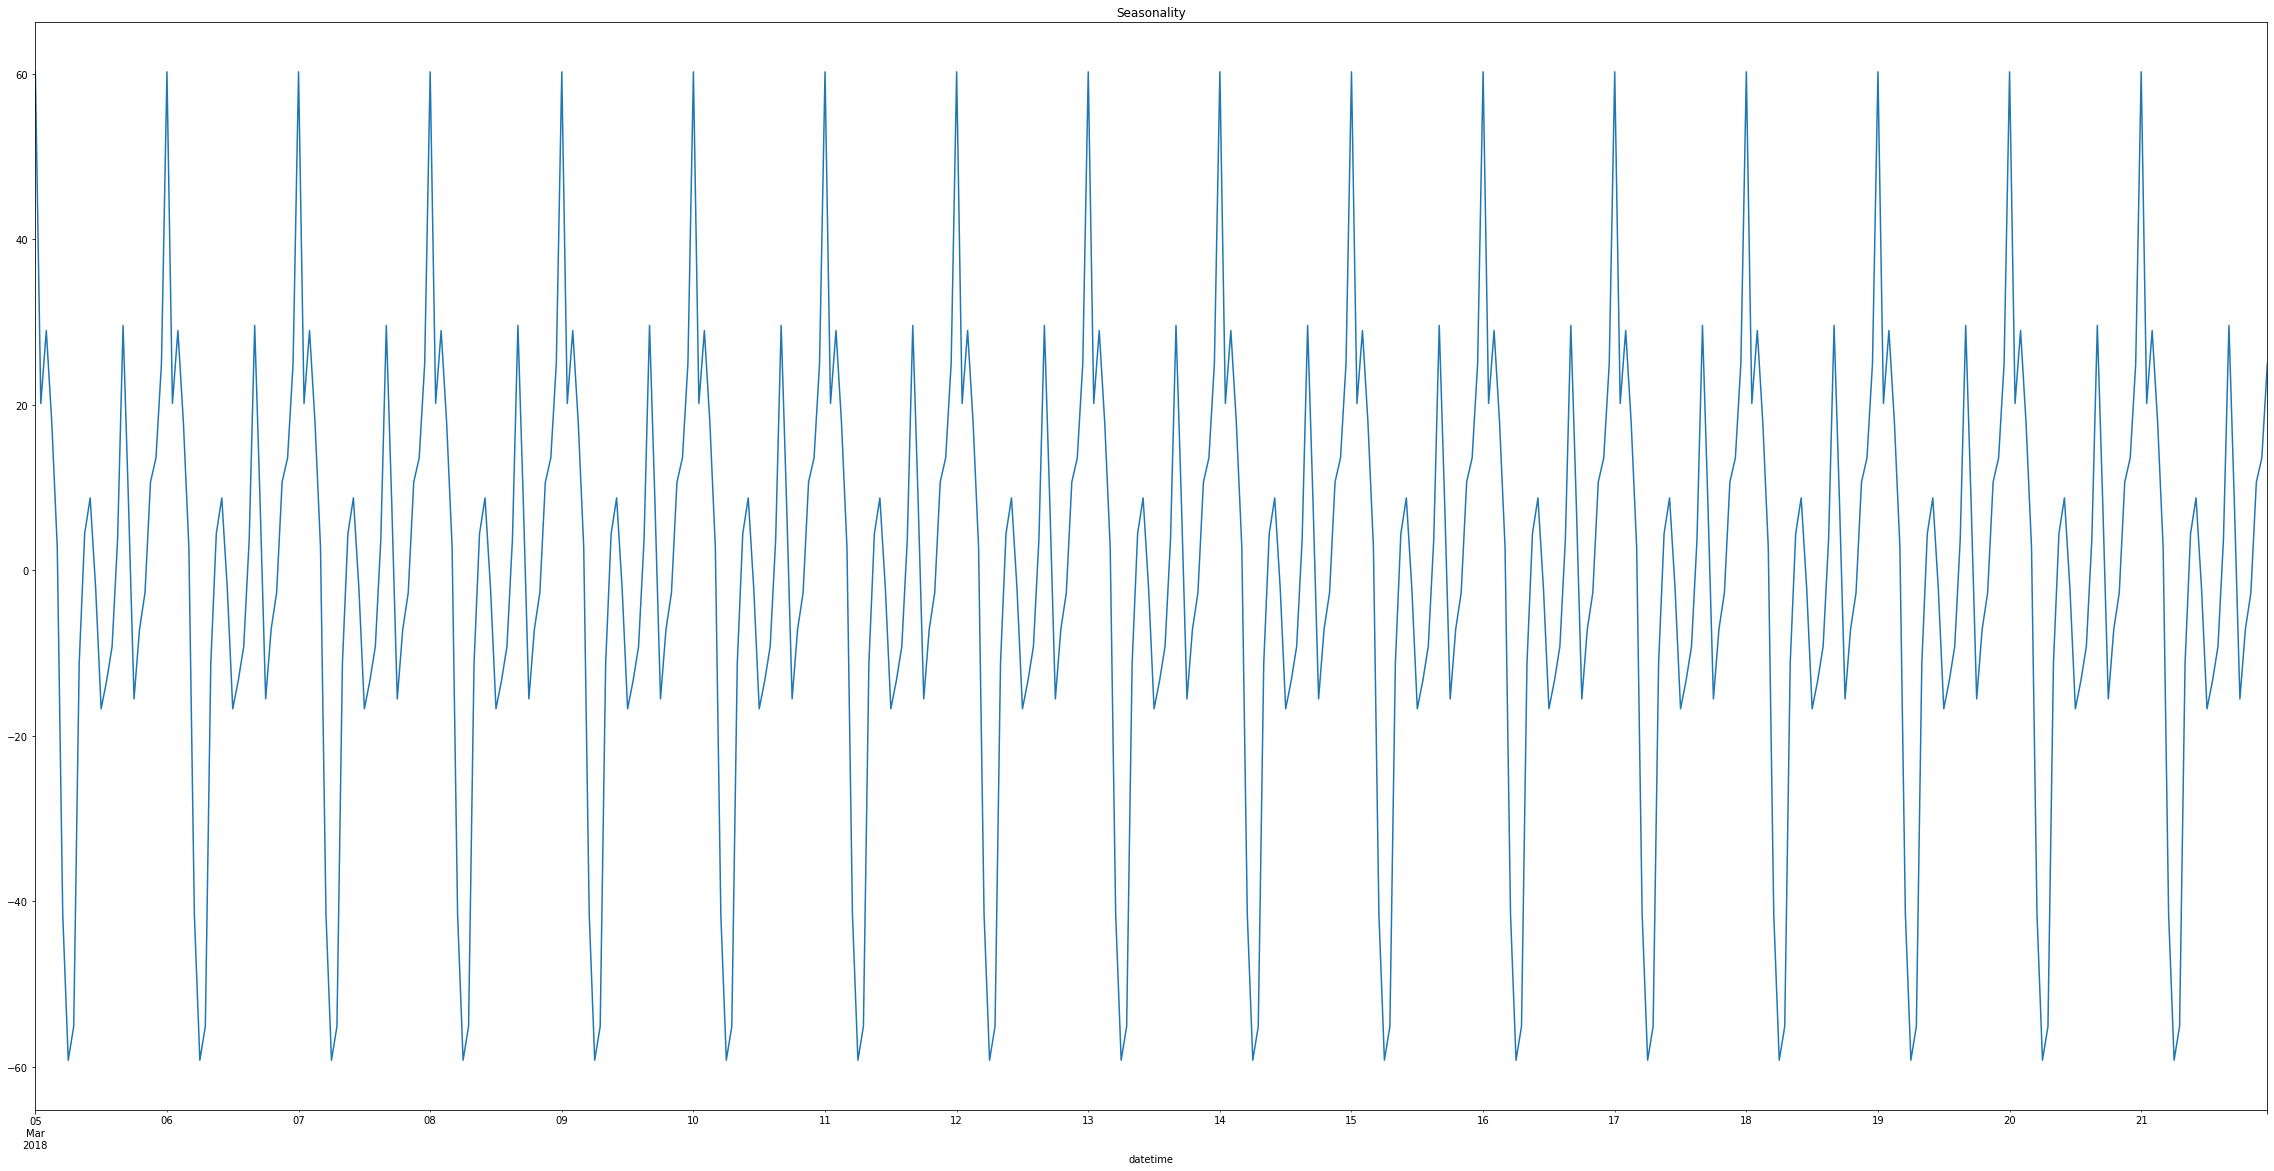

In [11]:

plt.figure(figsize=(40, 20))
decomposed = seasonal_decompose(df_res)
print(decomposed)
decomposed.seasonal['2018-03-05':'2018-03-21'].plot(ax=plt.gca()) 
plt.title('Seasonality')


Наблюдаем возрастание активности в утренние и вечерние часы. Около 00.00 активность резко снижается.  

Text(0.5, 1.0, 'Trend')

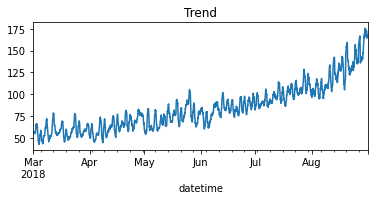

In [12]:
df_res.sort_index(inplace=True)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

На графике просматривается явный тренд на возрастание заказзов. 

Text(0.5, 1.0, 'Trend')

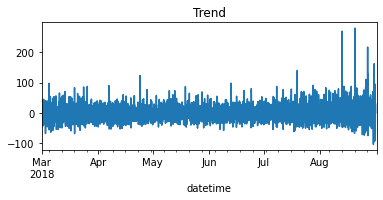

In [13]:
df_res.sort_index(inplace=True)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.resid .plot(ax=plt.gca())
plt.title('Trend')

### Обучение моделей

Создадим признаки для обучения. Для этого используем функции make_features

In [104]:

df_res.sort_index(inplace=True)

def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
#    data['dayofmonth'] = data.index.daysinmonth
    data['hour'] = data.index.hour   
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(4).mean()
    
    


make_features(df_res, 200, 3)

C:\Users\Владислав\AppData\Local\Temp\ipykernel_14380\2494300005.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\Владислав\AppData\Local\Temp\ipykernel_14380\2494300005.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\Владислав\AppData\Local\Temp\ipykernel_14380\2494300005.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [105]:
display(df_res.head())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


In [106]:
df_res = df_res[200:] #избавляемся от nan образовавшихся в рез-те шифта
features = df_res.drop('num_orders', axis = 1)
target = df_res['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, shuffle=False,  test_size=0.3, random_state=111)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, shuffle=False,  test_size=0.333, random_state=222)

In [107]:
target_test.shape

(422,)

In [108]:
df_res

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-09 08:00:00,36,4,8,16.0,4.0,1.0,30.0,31.0,29.0,66.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,12.75
2018-03-09 09:00:00,43,4,9,36.0,16.0,4.0,1.0,30.0,31.0,29.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,14.25
2018-03-09 10:00:00,43,4,10,43.0,36.0,16.0,4.0,1.0,30.0,31.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,24.75
2018-03-09 11:00:00,49,4,11,43.0,43.0,36.0,16.0,4.0,1.0,30.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,34.50
2018-03-09 12:00:00,24,4,12,49.0,43.0,43.0,36.0,16.0,4.0,1.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,42.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,82.0,160.0,187.0,180.0,122.0,112.0,88.0,143.0,124.0,184.25
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,95.0,82.0,160.0,187.0,180.0,122.0,112.0,88.0,143.0,189.25
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,182.0,95.0,82.0,160.0,187.0,180.0,122.0,112.0,88.0,178.50


#### LinearRegression

In [109]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predicted_valid_LR = model_LR.predict(features_valid)
print("RMSE LGBMRegressor на обучающей выборке:", mean_squared_error(target_valid, predicted_valid_LR)**0.5)
#scores_LR = cross_val_score(model_LR, features_train, target_train, scoring='neg_root_mean_squared_error')

RMSE LGBMRegressor на обучающей выборке: 27.0157068289238
CPU times: total: 62.5 ms
Wall time: 54.4 ms


#### LGBMRegressor

In [51]:
%%time
model_lgbm = LGBMRegressor()
model_lgbm.fit(features_train, target_train)
predicted_valid_lgbm = model_lgbm.predict(features_valid)
print("RMSE LGBMRegressor на обучающей выборке:", mean_squared_error(target_valid, predicted_valid_lgbm)**0.5)

RMSE LGBMRegressor на обучающей выборке: 29.731286269523306
CPU times: total: 2.78 s
Wall time: 745 ms


#### LGBMRegressor + GridSearch

In [29]:
%%time

model_lgbm = LGBMRegressor()

grid_space = {
    'n_estimators': [8,16,32,64,128,256],
    'max_depth': [3,9,18,27]
}

tscv = TimeSeriesSplit(n_splits=9)
grid = GridSearchCV(model_lgbm,param_grid=grid_space, scoring='neg_root_mean_squared_error',cv = tscv, verbose=1)
model_grid = grid.fit(features_train, target_train)

print('Лучшие параметры:', model_grid.best_params_)
print('Rmse:', model_grid.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Лучшие параметры: {'max_depth': 27, 'n_estimators': 64}
Rmse: -20.918718468546544
CPU times: total: 2min 56s
Wall time: 54.3 s


#### LGBMRegressor + RandSearch

In [52]:
%%time

model_lgbm_rs = LGBMRegressor()

rs_space = {
    'n_estimators': np.arange(1, 250, step=5),
    'max_depth': np.arange(3, 30, step=3)
}
tscv = TimeSeriesSplit(n_splits=10)
randsearch = RandomizedSearchCV(model_lgbm_rs, rs_space, n_iter=500, n_jobs=-1, cv=tscv,scoring='neg_root_mean_squared_error')
model_randsearch = randsearch.fit(features_train, target_train)
#predicted_test_lgbm_randsearch = randsearch.predict(features_test)

print('Лучшие параметры:', model_randsearch.best_params_)
print('Rmse:', model_randsearch.best_score_)

C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 450 is smaller than n_iter=500. Running 450 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'n_estimators': 76, 'max_depth': 3}
Rmse: -20.16048674040302
CPU times: total: 25.7 s
Wall time: 47min 33s


### CatBoostRegressor

In [53]:
%%time
model_cbr = CatBoostRegressor()

model_cbr.fit(features_train, target_train)
predicted_valid_cbr = model_cbr.predict(features_valid)
mean_squared_error(target_valid, predicted_valid_cbr)**0.5


Learning rate set to 0.048394
0:	learn: 33.4920583	total: 33ms	remaining: 32.9s
1:	learn: 32.6765162	total: 59.6ms	remaining: 29.7s
2:	learn: 31.9208752	total: 87.7ms	remaining: 29.2s
3:	learn: 31.1727005	total: 114ms	remaining: 28.4s
4:	learn: 30.4297963	total: 140ms	remaining: 28s
5:	learn: 29.7586564	total: 167ms	remaining: 27.6s
6:	learn: 29.1309257	total: 208ms	remaining: 29.5s
7:	learn: 28.5579904	total: 240ms	remaining: 29.8s
8:	learn: 27.9837387	total: 268ms	remaining: 29.5s
9:	learn: 27.4796576	total: 298ms	remaining: 29.5s
10:	learn: 26.9801888	total: 324ms	remaining: 29.1s
11:	learn: 26.5022461	total: 351ms	remaining: 28.9s
12:	learn: 26.0545144	total: 380ms	remaining: 28.8s
13:	learn: 25.6135981	total: 410ms	remaining: 28.9s
14:	learn: 25.2124543	total: 455ms	remaining: 29.9s
15:	learn: 24.8070065	total: 486ms	remaining: 29.9s
16:	learn: 24.4647156	total: 514ms	remaining: 29.7s
17:	learn: 24.1365519	total: 541ms	remaining: 29.5s
18:	learn: 23.8254636	total: 569ms	remaining:

29.59583148405066

#### Результаты исследования моделей

In [110]:
param = [
    ['LinearRegression','125 ms','27.24'],
    ['LGBMRegressor','1.45 s','30.4'],
    ['LGBMRegressor + GrirSearch','54.3 s','20.9'],
    ['LGBMRegressor + RandSearch','47min 33s','20.16'],
    ['CatBoostRegressor',' 1min 44s','29.59'],
]
model_list = ['Модель', 'Время обучения', 'RMSE']
 

 
pd.DataFrame(data=param , columns=model_list) 

,Модель,Время обучения,RMSE
0,LinearRegression,125 ms,27.24
1,LGBMRegressor,1.45 s,30.4
2,LGBMRegressor + GrirSearch,54.3 s,20.9
3,LGBMRegressor + RandSearch,47min 33s,20.16
4,CatBoostRegressor,1min 44s,29.59


## Тестирование

In [ ]:
pred_randsearch = model_randsearch.predict(features_test)
mean_squared_error(target_test, pred_randsearch)**0.5

Объединим в единую таблицу релаьные данные и предсказания, за тем по ним построим график

In [170]:
df_target_test = pd.DataFrame(target_test).reset_index()
df_pred_randsearch = pd.DataFrame(pred_randsearch)
df_chart = df_target_test
df_chart['pred']=df_pred_randsearch
#df_chart.head(1)
df_chart = df_chart.set_index('datetime')
df_chart_q = df_chart['2018-08-14 10:00:00':'2018-08-16 10:00:00']
df_chart

,num_orders,pred
datetime,,
2018-08-14 10:00:00,155,108.391394
2018-08-14 11:00:00,162,109.530429
2018-08-14 12:00:00,114,80.468665
2018-08-14 13:00:00,64,94.300293
2018-08-14 14:00:00,112,95.438053
...,...,...
2018-08-31 19:00:00,136,141.682650
2018-08-31 20:00:00,154,132.136352
2018-08-31 21:00:00,159,133.814152


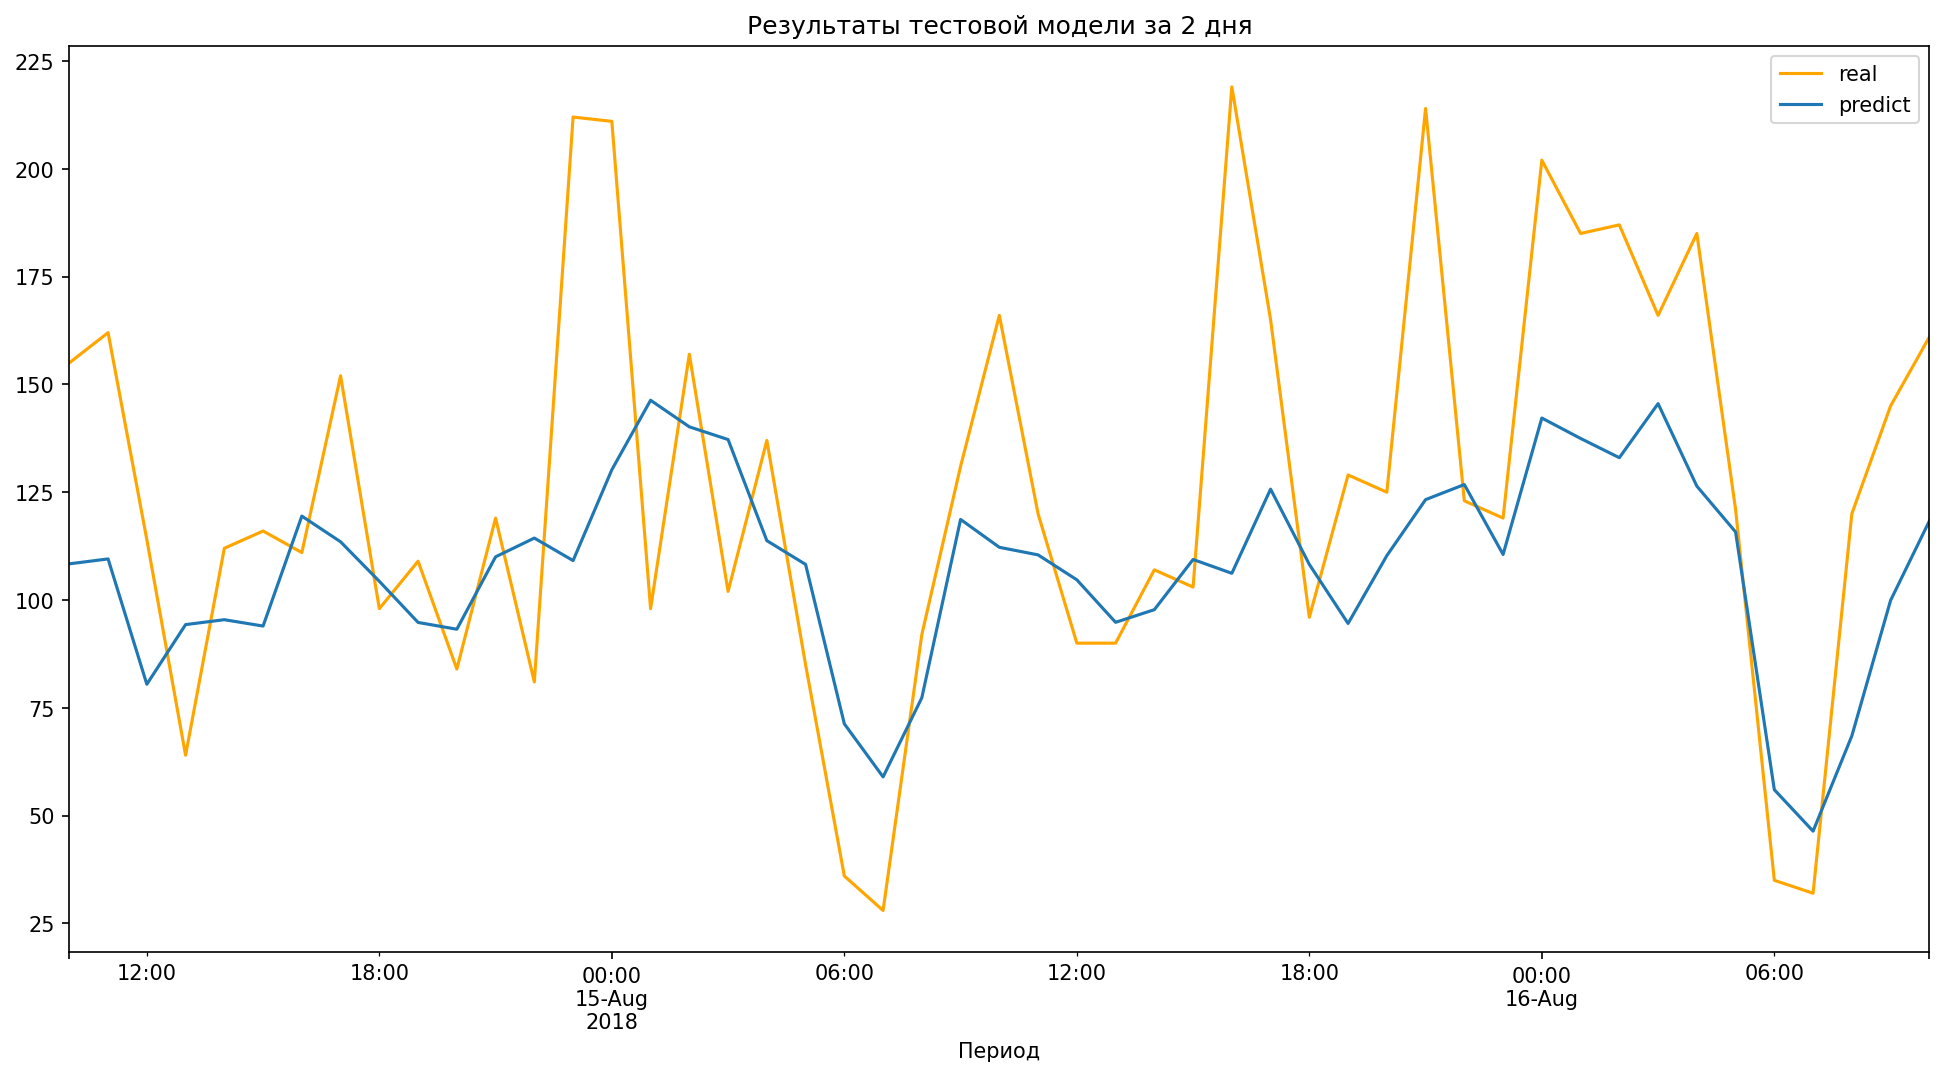

In [171]:

plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df_chart_q['num_orders'].plot(label='real', color='orange')
df_chart_q['pred'].plot(label='predict')

  
# adding title to the plot
plt.title('Результаты тестовой модели за 2 дня')
  
# adding Label to the x-axis
plt.xlabel('Период')
  
# adding legend to the curve
plt.legend()

## Вывод:

В рамках проекта была потавлена задача на основании исторических данных разработать модель обучения, которая предскажет пики заказов такси. Были протестированы: LinearRegression, LGBMRegressor, LGBMRegressor + RandSearch
LGBMRegressor + GridSearch, CatBoostRegressor. Лучший результат на валидационной выборке показала модель LGBMRegressor + RandSearch. LGBMRegressor + RandSearch была протестирована на сестовой выбоке, показала результаьт rmse 49.9